# Training model

## Install packages

In [1]:
import tensorflow as tf
import os

In [2]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "models/ssd_mobilenet_v2/pipeline.config"
PATH_TO_CKPT = "training_output/"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.06057000160217285 seconds


2022-08-30 12:17:20.726159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
category_index = label_map_util.create_category_index_from_labelmap("training_files/label_map.pbtxt",
                                                                    use_display_name=True)

Running inference for test.jpg... INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Done


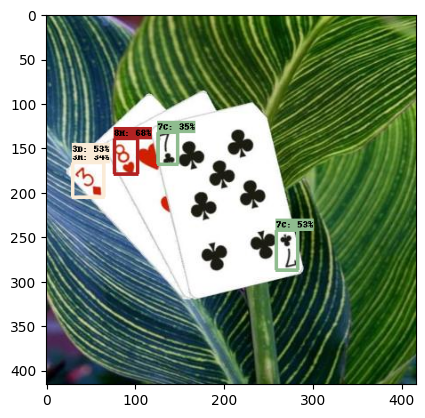

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
#warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

image_path="test.jpg"
print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

 # Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False)

plt.figure()
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2